In [1]:
import sys

sys.path.append("..")

In [2]:
from tensorflow import keras

In [3]:
from utils.preprocessing_utils import PreprocessingUtils

In [4]:
from utils.model_wrapper import ModelWrapper

In [5]:
preprocessing_utils = PreprocessingUtils()

Files already exist, skipping...
Loading images and labels...
Images and labels loaded successfully!
Preprocessing labels...
Labels preprocessed successfully!
Loading split data...
Split data loaded successfully!


In [6]:
def inception_module(x, filters: list[int]):
    tower_1 = keras.layers.Conv2D(
        filters[0], (1, 1), padding="same", activation="relu"
    )(x)
    tower_1 = keras.layers.Conv2D(
        filters[1], (3, 3), padding="same", activation="relu"
    )(tower_1)

    tower_2 = keras.layers.Conv2D(
        filters[2], (1, 1), padding="same", activation="relu"
    )(x)
    tower_2 = keras.layers.Conv2D(
        filters[3], (5, 5), padding="same", activation="relu"
    )(tower_2)

    tower_3 = keras.layers.AveragePooling2D((3, 3), strides=(1, 1), padding="same")(x)
    tower_3 = keras.layers.Conv2D(
        filters[4], (1, 1), padding="same", activation="relu"
    )(tower_3)

    tower_4 = keras.layers.Conv2D(
        filters[5], (1, 1), padding="same", activation="relu"
    )(x)

    concatenated = keras.layers.Concatenate(axis=-1)(
        [tower_1, tower_2, tower_3, tower_4]
    )
    return concatenated


def build_google_net(model_name: str):
    input_layer = keras.layers.Input(shape=preprocessing_utils.images.shape[1:])

    x = keras.layers.Conv2D(
        64,
        (7, 7),
        strides=(2, 2),
        padding="same",
        activation="relu",
        kernel_regularizer=keras.regularizers.l2(0.001),
    )(input_layer)
    x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

    x = keras.layers.Conv2D(
        64,
        (1, 1),
        padding="same",
        activation="relu",
        kernel_regularizer=keras.regularizers.l2(0.001),
    )(x)
    x = keras.layers.Conv2D(
        192,
        (3, 3),
        padding="same",
        activation="relu",
        kernel_regularizer=keras.regularizers.l2(0.001),
    )(x)
    x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

    x = inception_module(x, [64, 128, 32, 32, 32, 32])
    x = inception_module(x, [128, 192, 96, 64, 64, 64])

    x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(
        256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)
    )(x)
    x = keras.layers.Dropout(0.5)(x)

    output_layer = keras.layers.Dense(
        preprocessing_utils.num_classes, activation="softmax"
    )(x)

    model = keras.models.Model(
        name=model_name, inputs=input_layer, outputs=output_layer
    )

    model.compile(
        optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    model.summary()

    return model

In [7]:
google_net_wrapper = ModelWrapper("GoogleNet", preprocessing_utils=preprocessing_utils)

In [8]:
google_net_wrapper.build_model(
    build_fn=build_google_net, model_name=google_net_wrapper.model_name
)

Building model...
Model: "GoogleNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 64, 64, 64)   0           ['conv2d[0][0]']                 
                                                                        

In [9]:
google_net_wrapper.train_and_save_model_and_history(batch_size=32)

Epoch 1/100
129/129 [==============================] - ETA: 0s - loss: 3.8409 - accuracy: 0.0718
Epoch 1: val_loss improved from inf to 3.78519, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


129/129 [==============================] - 8s 36ms/step - loss: 3.8409 - accuracy: 0.0718 - val_loss: 3.7852 - val_accuracy: 0.0737 - lr: 0.0100
Epoch 2/100
127/129 [============================>.] - ETA: 0s - loss: 3.7454 - accuracy: 0.1058
Epoch 2: val_loss improved from 3.78519 to 3.67740, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


129/129 [==============================] - 4s 30ms/step - loss: 3.7446 - accuracy: 0.1056 - val_loss: 3.6774 - val_accuracy: 0.1106 - lr: 0.0100
Epoch 3/100
127/129 [============================>.] - ETA: 0s - loss: 3.5797 - accuracy: 0.1449
Epoch 3: val_loss improved from 3.67740 to 3.47360, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


129/129 [==============================] - 4s 29ms/step - loss: 3.5770 - accuracy: 0.1445 - val_loss: 3.4736 - val_accuracy: 0.1705 - lr: 0.0100
Epoch 4/100
127/129 [============================>.] - ETA: 0s - loss: 3.4610 - accuracy: 0.1639
Epoch 4: val_loss improved from 3.47360 to 3.46819, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


129/129 [==============================] - 4s 30ms/step - loss: 3.4604 - accuracy: 0.1644 - val_loss: 3.4682 - val_accuracy: 0.1152 - lr: 0.0100
Epoch 5/100
127/129 [============================>.] - ETA: 0s - loss: 3.3326 - accuracy: 0.1870
Epoch 5: val_loss improved from 3.46819 to 3.22338, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


129/129 [==============================] - 4s 30ms/step - loss: 3.3323 - accuracy: 0.1871 - val_loss: 3.2234 - val_accuracy: 0.1797 - lr: 0.0100
Epoch 6/100
127/129 [============================>.] - ETA: 0s - loss: 3.1546 - accuracy: 0.2276
Epoch 6: val_loss improved from 3.22338 to 3.03338, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


129/129 [==============================] - 4s 29ms/step - loss: 3.1496 - accuracy: 0.2294 - val_loss: 3.0334 - val_accuracy: 0.2627 - lr: 0.0100
Epoch 7/100
127/129 [============================>.] - ETA: 0s - loss: 2.9724 - accuracy: 0.2739
Epoch 7: val_loss improved from 3.03338 to 2.97975, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


129/129 [==============================] - 4s 30ms/step - loss: 2.9713 - accuracy: 0.2737 - val_loss: 2.9798 - val_accuracy: 0.2903 - lr: 0.0100
Epoch 8/100
127/129 [============================>.] - ETA: 0s - loss: 2.8647 - accuracy: 0.2926
Epoch 8: val_loss did not improve from 2.97975
129/129 [==============================] - 2s 19ms/step - loss: 2.8695 - accuracy: 0.2917 - val_loss: 3.0370 - val_accuracy: 0.2258 - lr: 0.0100
Epoch 9/100
127/129 [============================>.] - ETA: 0s - loss: 2.7300 - accuracy: 0.3457
Epoch 9: val_loss improved from 2.97975 to 2.84930, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


129/129 [==============================] - 4s 30ms/step - loss: 2.7302 - accuracy: 0.3457 - val_loss: 2.8493 - val_accuracy: 0.3318 - lr: 0.0100
Epoch 10/100
127/129 [============================>.] - ETA: 0s - loss: 2.5318 - accuracy: 0.3930
Epoch 10: val_loss improved from 2.84930 to 2.84871, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


129/129 [==============================] - 4s 29ms/step - loss: 2.5359 - accuracy: 0.3921 - val_loss: 2.8487 - val_accuracy: 0.3041 - lr: 0.0100
Epoch 11/100
127/129 [============================>.] - ETA: 0s - loss: 2.3395 - accuracy: 0.4491
Epoch 11: val_loss improved from 2.84871 to 2.75111, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


129/129 [==============================] - 4s 30ms/step - loss: 2.3424 - accuracy: 0.4490 - val_loss: 2.7511 - val_accuracy: 0.3594 - lr: 0.0100
Epoch 12/100
127/129 [============================>.] - ETA: 0s - loss: 2.1315 - accuracy: 0.5199
Epoch 12: val_loss improved from 2.75111 to 2.67310, saving model to ../../artifacts/checkpoints\checkpoint_GoogleNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_GoogleNet\assets


129/129 [==============================] - 4s 29ms/step - loss: 2.1315 - accuracy: 0.5203 - val_loss: 2.6731 - val_accuracy: 0.3871 - lr: 0.0100
Epoch 13/100
127/129 [============================>.] - ETA: 0s - loss: 1.9587 - accuracy: 0.5696
Epoch 13: val_loss did not improve from 2.67310
129/129 [==============================] - 2s 19ms/step - loss: 1.9548 - accuracy: 0.5704 - val_loss: 2.9278 - val_accuracy: 0.3456 - lr: 0.0100
Epoch 14/100
127/129 [============================>.] - ETA: 0s - loss: 1.7643 - accuracy: 0.6390
Epoch 14: val_loss did not improve from 2.67310
129/129 [==============================] - 2s 19ms/step - loss: 1.7667 - accuracy: 0.6385 - val_loss: 2.7855 - val_accuracy: 0.3917 - lr: 0.0100
Epoch 15/100
127/129 [============================>.] - ETA: 0s - loss: 1.5983 - accuracy: 0.7052
Epoch 15: val_loss did not improve from 2.67310
129/129 [==============================] - 3s 19ms/step - loss: 1.6031 - accuracy: 0.7030 - val_loss: 3.1148 - val_accuracy: 0.

In [10]:
google_net_wrapper.load_model_and_history()

Loading model from "../../artifacts/models/GoogleNet.h5"...
Model loaded successfully!
Loading history from "../../artifacts/model_histories/history_GoogleNet"...
History loaded successfully!


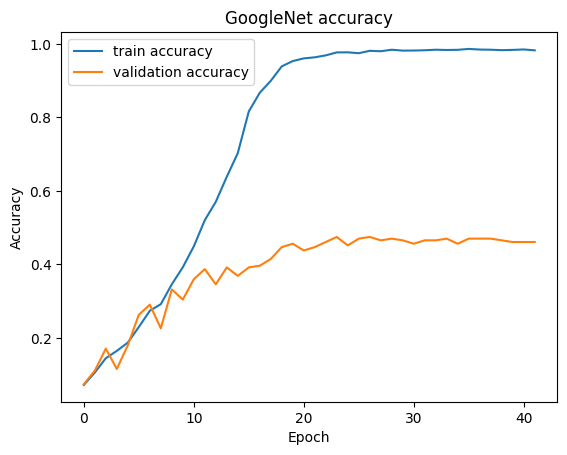

In [11]:
google_net_wrapper.plot_accuracy()

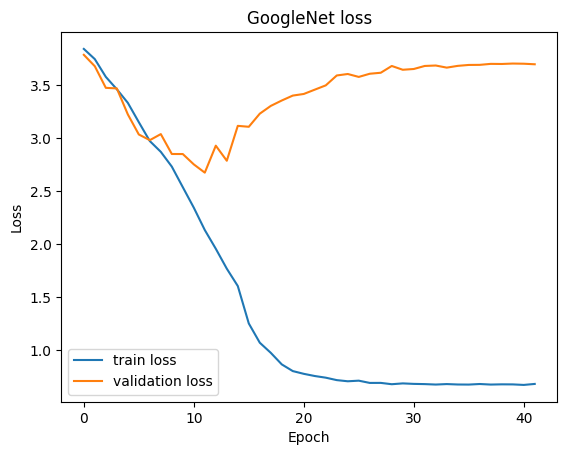

In [12]:
google_net_wrapper.plot_loss()

20/20 [==============================] - 0s 12ms/step - loss: 3.6399 - accuracy: 0.4604
Loss: 3.6399
Accuracy: 0.4604
20/20 [==============================] - 0s 8ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.39      0.47        23
           1       0.45      0.36      0.40        25
           2       0.60      0.65      0.62        52
           3       0.30      0.26      0.28        38
           4       0.38      0.33      0.35        27
           5       0.42      0.49      0.45        35
           6       0.55      0.38      0.45        45
           7       0.00      0.00      0.00        10
           8       0.71      0.42      0.53        12
           9       0.33      0.45      0.38        11
          10       0.43      0.43      0.43        23
          11       0.45      0.58      0.51        26
          12       0.29      0.38      0.32        32
          13       0.40      0.40      0.40      

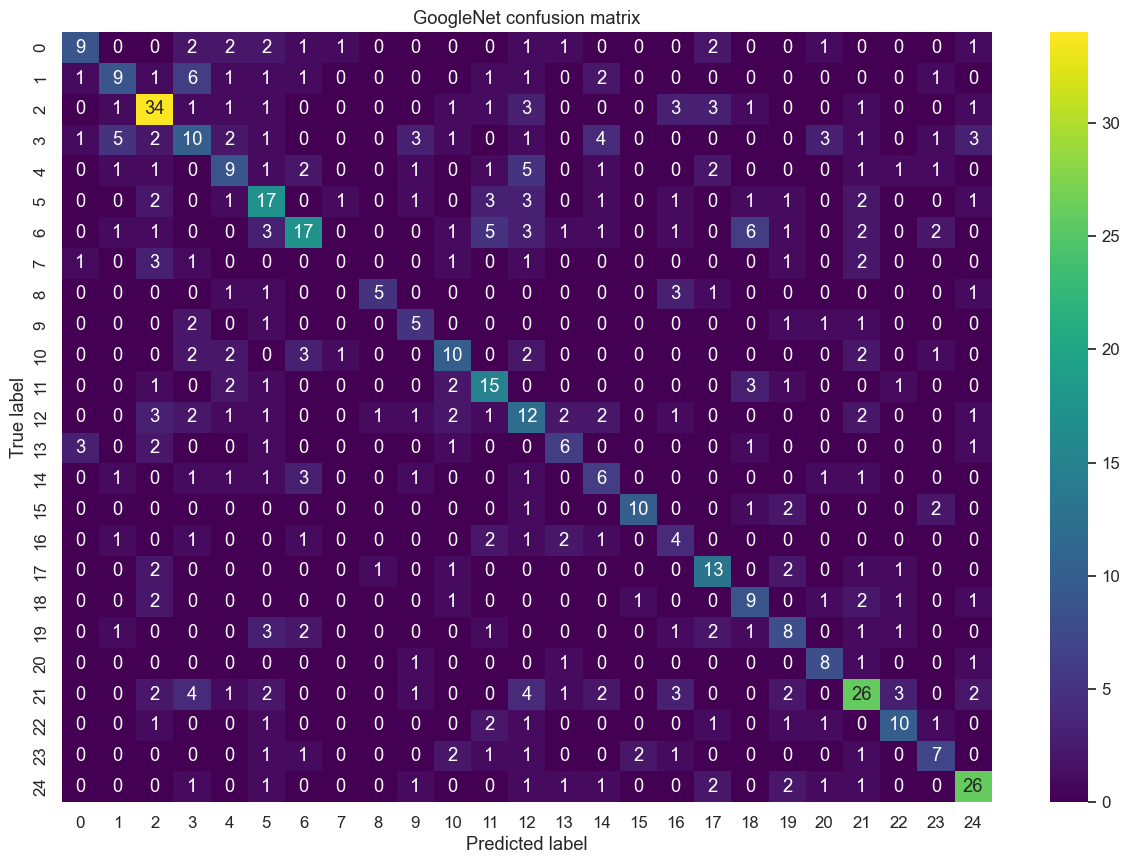

In [13]:
google_net_wrapper.display_evaluation_results()